# Tutorial 3: Star Mapping
Prepared by the International Centre for Neuromorphic Systems (ICNS) at Western Sydney University for the AMOS Conference 2023.

***UPDATE*** These tutorials have been updated and now can be run directly in Google CoLab. Click [here]( https://colab.research.google.com/github/gcohen/AMOS-Short-Course/blob/main/Tutorial3.ipynb) to open this tutorial directy in Google CoLab.

## Introduction

***What you will learn***
In this tutorial, we will work with real-world event-based data to learn how to load and process it. 

By the end of this tutorial, you will...
* Be able to load and view event-based star data
* Warp event temporally to stabilise stars
* Find the centres of the stars
* Perform an astrometry fit on the data




## Getting Started

This tutorial builds upon the previous tutorials and exercises but requires the installation of a few additional packages:


Firsly, we will need the fantastic [astropy](https://www.astropy.org/) library to work with star coordinate systems. We will also make use of a Python package called [astrometry](https://github.com/neuromorphicsystems/astrometry), which is a Python wrapper around Astrometry.net that accepts star positions and can be used to perform plate solving. These two packages can be installed using the following command

```bash
    pip install astropy requests astrometry
```

We will also require a few additional packages for plotting and clustering. These can be installed using the following command:
```bash
    pip install scikit-image matplotlib-label-lines
```

**Note:** If you are using Python in `Anaconda`, `matplotlib` and `numpy` may already be installed, but it's worth checking.  If you are using `Anaconda`, don't forget to use `conda` instead of pip!!


If you are running this tutorial on Google Colab, simply run the Python code below to install the required libraries:

In [ ]:
# Install the required dependencies (if not already installed). This is required to install the required packages in Google Co-Lab.
!pip3 install event_stream astropy requests astrometry scikit-image matplotlib-label-lines

### Downloading the data

If you are running this tutorial on Google Colab, you will need to download the required data file from Github. The command below will automatically download the correct file and place it in the same directory as this tutorial. If you are running the tutorial locally, you may already have this file locally and do not need to download it again. The data file can be found in the Github repository at `/Data/WSU/g4all2022-02-11T09.27.35_cut.es`.

Note that this data file is approximtely 55 Mb in size. It may take a few minutes to download.

In [1]:
# Download the sample data from Github
import urllib.request
filename = urllib.request.urlretrieve("https://github.com/gcohen/AMOS-Short-Course/raw/main/Data/WSU/g4all2022-02-11T09.27.35_cut.es", "g4all2022-02-11T09.27.35_cut.es")

First, we need to load the data. We for simplicity and ease-of-use, we will load all the data into a single variable in memory.

In [2]:
import event_stream
import numpy

with event_stream.Decoder("g4all2022-02-11T09.27.35_cut.es") as decoder:
    width = decoder.width
    height = decoder.height
    events = numpy.concatenate(list(decoder))

### Optimisations using `numpy`

Whilst Python is very convenient for prototyping and exploring event-based code, it is not very efficient in terms of processing. However, the `numpy` package provides functions that are highly optimised and therefore can greatly speed up code execution. 

The numpy operation `numpy.add.at(frame, (height - 1 - events["y"], events["x"]), 1)` is equivalent to the following Python code (but 20 times faster):
```py
for t, x, y, p in events:
    frame[height - 1 - y, x] += 1
```

Matplolib treats images as matrices with y (the row) as the first coordinate while `(0, 0)` is at the bottom-left in Event Stream files (following the usual maths convention), hence the inversion of the y coordinate with `height - 1 - y`.

In [3]:
accumulated_frame = numpy.ones((height, width)) # use ones instead of zeros to avoid problems with LogNorm
numpy.add.at(accumulated_frame, (height - 1 - events["y"], events["x"]), 1)

### Visualising the event-based data

Let's plot the accumulated frame to show a summary of all the data in the file. We can do that as follows:

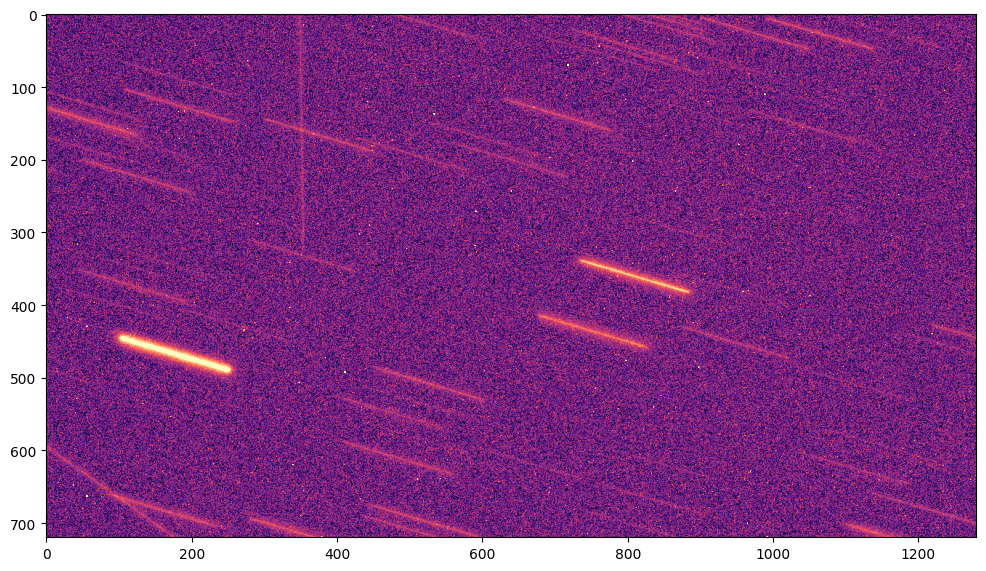

In [4]:
import matplotlib
import matplotlib.colors
import matplotlib.pyplot
import matplotlib.transforms

matplotlib.rcParams["figure.figsize"] = [12, 8]

matplotlib.pyplot.imshow(
    accumulated_frame,
    norm=matplotlib.colors.LogNorm(vmax=numpy.percentile(accumulated_frame, 99.9)),
    cmap="magma",
)

### Event Warping

Now, we will warp the events based on the known sidereal motion of the stars. We can do that using the following code:

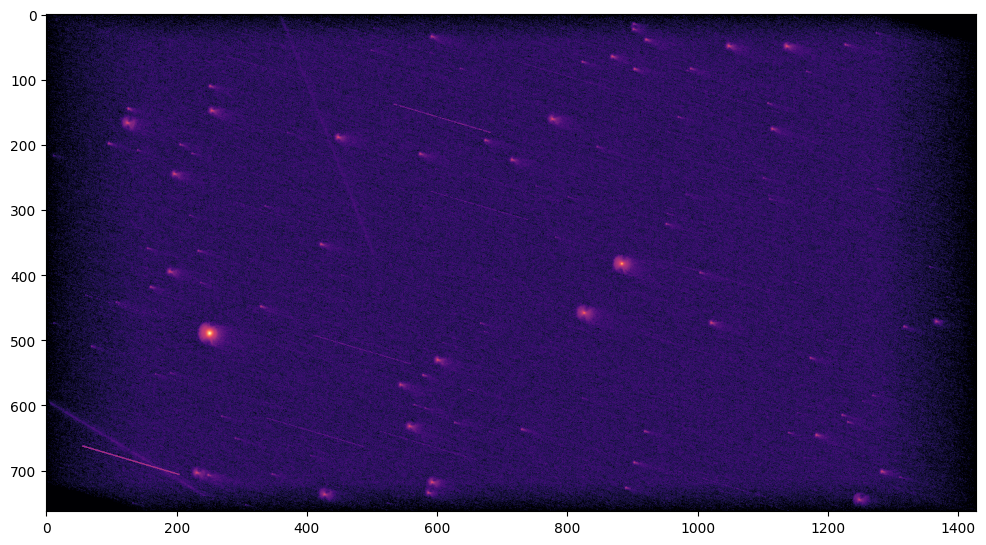

In [5]:
vx = -1.861  # px/s
vy = 0.549  # px/s

t0 = events["t"][0]
duration = events["t"][-1] - t0

warped_events = numpy.zeros(len(events), dtype=events.dtype)

# warp the events (shear operation)
warped_events["t"] = events["t"]
if vx > 0:
    warped_events["x"] = events["x"] + numpy.floor(
        (vx / 1e6) * (duration - (events["t"] - t0))
    )
else:
    warped_events["x"] = events["x"] + numpy.floor((-vx / 1e6) * (events["t"] - t0))
if vy > 0:
    warped_events["y"] = events["y"] + numpy.floor(
        (vy / 1e6) * (duration - (events["t"] - t0))
    )
else:
    warped_events["y"] = events["y"] + numpy.floor((-vy / 1e6) * (events["t"] - t0))
warped_events["on"] = events["on"]

# accumulate the warped events
warped_accumulated_frame = numpy.ones(
    (
        height + int(numpy.floor(abs(vy / 1e6) * duration)),
        width + int(numpy.floor(abs(vx / 1e6) * duration)),
    )
)
numpy.add.at(
    warped_accumulated_frame,
    (warped_accumulated_frame.shape[0] - 1 - warped_events["y"], warped_events["x"]),
    1,
)

# display the result
matplotlib.pyplot.imshow(
    warped_accumulated_frame, 
    norm=matplotlib.colors.LogNorm(), 
    cmap="magma",
)

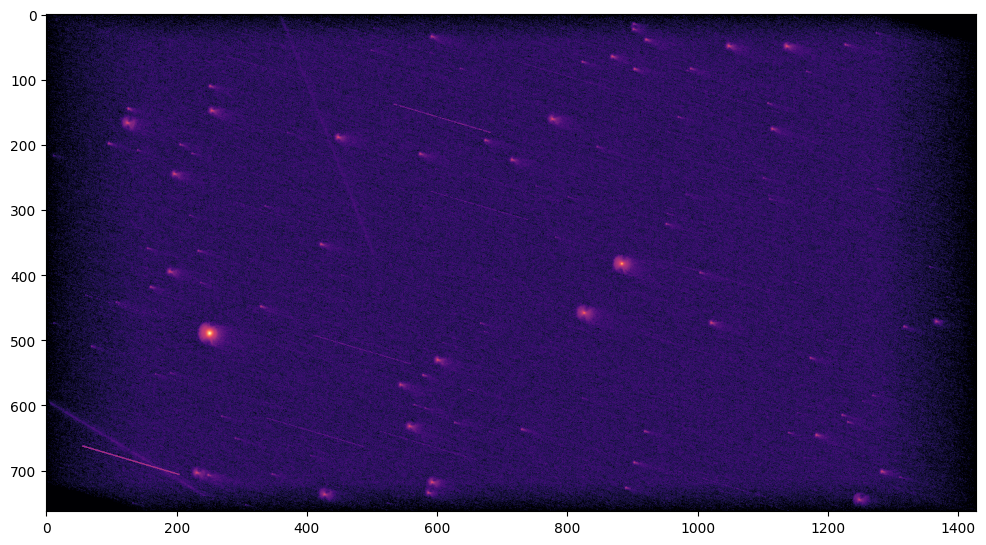

In [9]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(vx = -1.861, vy = 0.549)
def warp_events_vxvy(vx = -1.861, vy = 0.549):
    t0 = events["t"][0]
    duration = events["t"][-1] - t0

    warped_events = numpy.zeros(len(events), dtype=events.dtype)

    # warp the events (shear operation)
    warped_events["t"] = events["t"]
    if vx > 0:
        warped_events["x"] = events["x"] + numpy.floor(
            (vx / 1e6) * (duration - (events["t"] - t0))
        )
    else:
        warped_events["x"] = events["x"] + numpy.floor((-vx / 1e6) * (events["t"] - t0))
    if vy > 0:
        warped_events["y"] = events["y"] + numpy.floor(
            (vy / 1e6) * (duration - (events["t"] - t0))
        )
    else:
        warped_events["y"] = events["y"] + numpy.floor((-vy / 1e6) * (events["t"] - t0))
    warped_events["on"] = events["on"]

    # accumulate the warped events
    warped_accumulated_frame = numpy.ones(
        (
            height + int(numpy.floor(abs(vy / 1e6) * duration)),
            width + int(numpy.floor(abs(vx / 1e6) * duration)),
        )
    )
    numpy.add.at(
        warped_accumulated_frame,
        (warped_accumulated_frame.shape[0] - 1 - warped_events["y"], warped_events["x"]),
        1,
    )

    # display the result
    matplotlib.pyplot.imshow(
        warped_accumulated_frame, 
        norm=matplotlib.colors.LogNorm(), 
        cmap="magma",
    )




### Filtering the image to remove noise

The above image looks far better, but there are still some events that have left small trails in the data. We can clean this up slightly by applying a simple median filter tot he image. 

In [ ]:
import PIL.Image
import PIL.ImageChops
import PIL.ImageFilter

image = PIL.Image.fromarray(warped_accumulated_frame)
filtered_image = image.filter(PIL.ImageFilter.MedianFilter(5))
filtered_accumulated_frame = numpy.array(filtered_image)

matplotlib.pyplot.imshow(
    filtered_accumulated_frame, 
    norm=matplotlib.colors.LogNorm(), 
    cmap="magma",
)

### Labelling stars in the image

To find the stars within this image, we will use a labeling technique provided by `scikit.image`. We will be using the [label](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.label) function, which looks for connected regions within the image and assigns them individual and unique labels. The label function considers pixels connected if they are adjacent and have the same value. 

In order to improve the labeling process, we will take the above image and make a binary image out of it. We can do this using the 99.5% percentile to remove a large portion of the noise in the field of view. We can use the code below to make the binary mask of our star map: 

In [ ]:
nonzero = filtered_accumulated_frame[filtered_accumulated_frame > 0.0]
binary_mask = filtered_accumulated_frame > numpy.percentile(nonzero, 99.5)

matplotlib.pyplot.imshow(
    binary_mask,
    cmap="gray",
    interpolation=None,
    interpolation_stage="rgba",
)

The code below uses the binary mask to label the stars in the image. It generates a random colour map based on the number of stars identified in the recording.

In [ ]:
import skimage.measure

labels_array, maximum_label = skimage.measure.label(binary_mask, connectivity=1, background=0, return_num=True)

# manually generate a colormap to visualise the result of connected components analysis
labels_colors = numpy.array([[0.0, 0.0, 0.0, 1.0]])
while len(labels_colors) < maximum_label + 1:
    new_colors = matplotlib.colormaps["Set2"](numpy.linspace(1/16, 15/16, 8))[0:maximum_label + 1 - len(labels_colors)]
    numpy.random.shuffle(new_colors)
    labels_colors = numpy.concatenate([labels_colors, new_colors])

matplotlib.pyplot.imshow(
    labels_array + 0.5,
    cmap=matplotlib.colors.ListedColormap(labels_colors),
    interpolation=None, 
    interpolation_stage="rgba"
)

### Labeling the raw events

The code above detected stars using the accumulated frame of events generated from the event-based data. We therefore have labelled regions of the above image and now need to map that back to the raw events received from the camera. To do this, we will extend the definition of the event to include an additional value indicating the label to which the event is attached.

We can do this on the warped events and apply these labels to the events directly. We could also reverse the event-warping and label the original events too. However, this isn't necessary for star mapping.

Note that we added a default background label, and therefore any events that are not stars will be mapped to the background label.

In [ ]:
labelled_events = numpy.zeros(
    len(warped_events),
    dtype=[
        ("t", "<u8"),
        ("x", "<u2"),
        ("y", "<u2"),
        ("on", "?"),
        ("label", "<u4"),
    ],
)

labelled_events["t"] = warped_events["t"]
labelled_events["x"] = warped_events["x"]
labelled_events["y"] = warped_events["y"]
labelled_events["on"] = warped_events["on"]
labelled_events["label"] = labels_array[warped_accumulated_frame.shape[0] - 1 - warped_events["y"], warped_events["x"]]

### Finding the star centres

Now that we have labelled events, we can then iterate through them and calculate the mean position of the events to get the star centre. 

In [ ]:
centers = numpy.zeros((maximum_label + 1, 2))
for label in range(1, maximum_label + 1):
    centers[label] = (
        numpy.mean(labelled_events["x"][labelled_events["label"] == label]),
        numpy.mean(labelled_events["y"][labelled_events["label"] == label]),
    )

### Plotting the labelled stars

The code below plots a weighted version of the star map and the plots circles based on the detected star circles. 

In [ ]:
labelled_accumulated_frame = numpy.zeros(
    (
        3,
        height + int(numpy.floor(abs(vy / 1e6) * duration)),
        width + int(numpy.floor(abs(vx / 1e6) * duration)),
    )
)
for label in range(1, maximum_label + 1):
    source_events = labelled_events[labelled_events["label"] == label]
    source_alpha = numpy.zeros(
        (labelled_accumulated_frame.shape[1], labelled_accumulated_frame.shape[2])
    )
    numpy.add.at(
        source_alpha,
        (
            source_alpha.shape[0] - 1 - source_events["y"],
            source_events["x"],
        ),
        1,
    )
    source_alpha = (source_alpha / source_alpha.max()) ** 0.25
    source_accumulated_frame = numpy.zeros(labelled_accumulated_frame.shape)
    source_accumulated_frame[0, :, :] = labels_colors[label][0]
    source_accumulated_frame[1, :, :] = labels_colors[label][1]
    source_accumulated_frame[2, :, :] = labels_colors[label][2]
    labelled_accumulated_frame = numpy.multiply(
        labelled_accumulated_frame, 1.0 - source_alpha
    ) + numpy.multiply(source_accumulated_frame, source_alpha)
labelled_accumulated_frame = numpy.transpose(labelled_accumulated_frame, (1, 2, 0))
matplotlib.pyplot.imshow(labelled_accumulated_frame)
matplotlib.pyplot.scatter(
    x=centers[:, 0],
    y=source_alpha.shape[0] - 1 - centers[:, 1],
    marker="o",
    facecolor="none",
    edgecolors="#ffffff",
    linewidth=0.4,
    s=100,
)

### Performing the astrometry fit

**WARNING: The following code will download the astrometry caches files when first run. This will be approximately 650 Mb in size.**

Now that we have a list of star centres, we can now use the `astrometry` library to perform an astrometric fit on the data. The `astrometry` library is build around `Astrometry.Net` and was specially written to perform plate-solving on lists of star positions, rather than images. It provides a high-level programmatic interface and automatically handles the downloading of the necessary index files.

To perform the star mapping, we can use the following code to do the plate-solving:

In [ ]:
import astrometry
import logging

logging.getLogger().setLevel(logging.INFO)

# see https://github.com/neuromorphicsystems/astrometry for documentation

solver = astrometry.Solver(
    astrometry.series_5200_heavy.index_files(
        cache_directory="astrometry_cache",
        scales={6},
    )
)

solution = solver.solve(
    stars=centers,
    size_hint=None,
    position_hint=None,
    solution_parameters=astrometry.SolutionParameters(),
)

assert solution.has_match()

### Plotting the results

Now that we have a fit, we can use `astropy` to convert from the RA/DEC coordinates back to pixel space. We can also retrieve the star magnitudes from the `astrometry` fit. we will use this to scale the star accordingly.

In [ ]:
import astropy.wcs
import labellines

match = solution.best_match()
wcs = astropy.wcs.WCS(match.wcs_fields)

# convert stars RA/Dec to pixels
stars = wcs.all_world2pix(
    [[star.ra_deg, star.dec_deg] for star in match.stars],
    0,
)

# retrieve stars magnitudes (requires series_5200_heavy)
magnitudes = numpy.array([star.metadata["mag"] for star in match.stars])
scaled_magnitudes = 1.0 - (magnitudes - magnitudes.min()) / (
    magnitudes.max() - magnitudes.min()
)

# draw the accumulated frame
matplotlib.pyplot.imshow(labelled_accumulated_frame)

# plot grid lines (one line per degree)
grid_ra = numpy.arange(
    numpy.floor(match.center_ra_deg - match.scale_arcsec_per_pixel / 3600 * width * 2),
    numpy.ceil(match.center_ra_deg + match.scale_arcsec_per_pixel / 3600 * width * 2),
)
grid_dec = numpy.arange(
    numpy.floor(match.center_dec_deg - match.scale_arcsec_per_pixel / 3600 * width * 2),
    numpy.ceil(match.center_dec_deg + match.scale_arcsec_per_pixel / 3600 * width * 2),
)
for ra in grid_ra:
    points = wcs.all_world2pix([[ra, dec] for dec in grid_dec], 0)
    matplotlib.pyplot.plot(
        points[:, 0],
        source_alpha.shape[0] - 1 - points[:, 1],
        color="#aaaaaa",
        linewidth=0.4,
    )
    lines = matplotlib.pyplot.gca().get_lines()
    labellines.labelLine(
        line=lines[-1],
        x=points[len(points) // 2, 0] - 75,
        label=f"RA = {ra:.0f}º",
        backgroundcolor="none",
        outline_color="#000000",
    )

for dec in grid_dec:
    points = wcs.all_world2pix([[ra, dec] for ra in grid_ra], 0)
    matplotlib.pyplot.plot(
        points[:, 0],
        source_alpha.shape[0] - 1 - points[:, 1],
        color="#aaaaaa",
        linewidth=0.4,
    )
    lines = matplotlib.pyplot.gca().get_lines()    
    labellines.labelLine(
        line=lines[-1],
        x=points[len(points) // 2, 0] - 200,
        label=f"Dec = {dec:.0f}º",
        backgroundcolor="none",
        outline_color="#000000",
    )

# plot events centers of mass
matplotlib.pyplot.scatter(
    x=centers[:, 0],
    y=source_alpha.shape[0] - 1 - centers[:, 1],
    marker="o",
    facecolor="none",
    edgecolors="#ffffff",
    linewidth=0.4,
    s=100,
)

# plot stars
matplotlib.pyplot.scatter(
    x=stars[:, 0],
    y=source_alpha.shape[0] - 1 - stars[:, 1],
    marker="o",
    facecolor="none",
    edgecolors=[
        f"#de5246{int(magnitude):02x}"
        for magnitude in numpy.floor((scaled_magnitudes**0.5) * 255)
    ],
    linewidth=1.0,
    s=scaled_magnitudes * 200.0,
)

matplotlib.pyplot.xlim((0.0, source_alpha.shape[1]))
matplotlib.pyplot.ylim((source_alpha.shape[0], 0.0))